In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

1. Intraday Volatility–Next-Day Predictors
Realized Volatility (RV):
Compute realized variance (sum of squared intraday returns).
High realized vol on day T often predicts high volatility on T+1.
Trade volatility (straddles, variance swaps) or size exposure accordingly.

Range-Based Volatility:
Parkinson (high–low) or Garman-Klass estimators.
Strong range today → higher chance of wide move tomorrow.

2. Intraday Momentum & Reversal
Intraday Return Shape:
Stocks that trend upward steadily during T often show positive autocorrelation into T+1 (short-term continuation).
Stocks with large late-day reversals often mean-revert the next day.

Open-to-Close vs. Close-to-Close:
If most of T’s gain comes from overnight (close-to-open), not from intraday trading (open-to-close), then weak demand exists → negative signal for T+1.
If intraday move is strong and persistent → positive T+1 continuation signal.

6. Volatility & Liquidity Regimes
Liquidity Dry-Up Predictor:
If volume collapses on day T but price still moves → fragile order book. T+1 tends to see reversals.
High Intraday Vol + Low Close Volume:
Indicates speculator-driven trading, not institutional. T+1 reverts more often.

In [ ]:
def vwap_strat1(df, results, dates):  # good
    # Calculate T_last_close and T_vap (VWAP)
    results["T_last_close"] = [
        df.loc[date]["Close"].iloc[-1] for date in dates
    ]
    results["T_vap"] = [
        (df.loc[date]["Close"] * df.loc[date]["Volume"]).sum() /
        df.loc[date]["Volume"].sum()
        for date in dates
    ]

    # if the last close price is higher than VWAP (T_vap), sell (-1), otherwise buy (+1)
    ratio = np.array(results["T_last_close"]) / np.array(results["T_vap"])
    
    return np.where(ratio > 1., -1, 1)

def vwap_strat2(df, results, dates):  # bad
    results['High'] = [
        df.loc[date]['High'].max() for date in dates
    ]
    results['Low'] = [
        df.loc[date]['Low'].min() for date in dates
    ]
    results["T_vap"] = [
        (df.loc[date]["Close"] * df.loc[date]["Volume"]).sum() /
        df.loc[date]["Volume"].sum()
        for date in dates
    ]

    geom_mean = np.sqrt(np.array(results['High']) * np.array(results['Low']))
    difference = np.array(geom_mean) - np.array(results["T_vap"])

    return np.where(difference > 0., -1, 1)

def rank_st(df, results, dates, target_col):  # mid
    for index in df.columns:
        open, close = [], []
        for date in dates:
            if len(df[index].loc[date]) == 0:
                open.append(np.nan)
                close.append(np.nan)
            else:
                open.append(df[index].loc[date]["Open"].iloc[0])
                close.append(df[index].loc[date]["Close"].iloc[-1])
        results[index] = -1 * (1 - np.array(open) / np.array(close))

    ranks = results.rank(axis=1, method="average", ascending=False)
    
    # 因子值高 → 今天跌得多 → 明天可能反弹 → 买入
    # 因子值低 → 今天涨得多 → 明天可能回落 → 卖出
    return np.where(ranks[target_col] <= 2, 1, -1)

def correlation_st(df, results, dates):  # bad
    results['Open'] = [
        df.loc[date]['Open'].iloc[0] for date in dates
    ]
    results['Volume'] = [
        df.loc[date]['Volume'].sum() for date in dates
    ]

    factors = -results["Open"].rolling(10, min_periods=8).corr(results["Volume"])

    return np.where(factors > 0, -1, 1)

def amplitude_st(df, results, dates):  # ok
    results["Amplitude"] = [
        (df.loc[date]["High"].max() - df.loc[date]["Low"].min()) / df.loc[date]["Open"].iloc[0]
        for date in dates
    ]

    return np.where(np.array(results["Amplitude"]) > np.median(results["Amplitude"]), 1, -1)

def close_pos_st(df, results, dates):  # good
    results["Pos"] = [
        (df.loc[date]["Close"].iloc[-1] - df.loc[date]["Low"].min()) /
        (df.loc[date]["High"].max() - df.loc[date]["Low"].min() + 1e-9)
        for date in dates
    ]

    return np.where(np.array(results["Pos"]) >= 0.6, -1, 1)

def volume_st1(df, results, dates, lookback=5):  # bad
    results["Volume"] = [df.loc[date]["Volume"].sum() for date in dates]

    vol_series = pd.Series(results["Volume"])
    ratio = vol_series / vol_series.rolling(lookback, min_periods=2).mean()

    return np.where(ratio > 1.5, -1, 1)  # 量能爆发 → 买入

def reversal_st(df, results, dates):  # ok
    opens = [df.loc[date]["Open"].iloc[0] for date in dates]
    closes = [df.loc[date]["Close"].iloc[-1] for date in dates]
    results["Reversal"] = np.array(closes) - np.array(opens)

    return np.where(results["Reversal"] > 0, -1, 1)

def rank_reversal_st(df, results, dates, target_col):  # mid
    for index in df.columns:
        opens, closes = [], []
        for date in dates:
            if len(df[index].loc[date]) == 0:
                opens.append(np.nan)
                closes.append(np.nan)
            else:
                opens.append(df[index].loc[date]["Open"].iloc[0])
                closes.append(df[index].loc[date]["Close"].iloc[-1])
        results[index] = np.array(closes) - np.array(opens)

    ranks = results.rank(axis=1, method="average", ascending=False)
    
    return np.where(ranks[target_col] < 2, -1,  # 涨最多 → 卖出
            1)

def momentum_st1(df, results, dates):  # ok
    opens = [df.loc[date]["Open"].iloc[0] for date in dates]
    closes = [df.loc[date]["Close"].iloc[-1] for date in dates]
    results["ln"] = np.log(np.array(opens) / np.array(closes))
    results['delta'] = results['ln'].diff().fillna(0)

    return np.where(results["delta"] < 0, -1, 1)

def volume_st2(df, results, dates): # bad
    results["T_vap"] = [
        (df.loc[date]["Close"] * df.loc[date]["Volume"]).sum() /
        df.loc[date]["Volume"].sum()
        for date in dates
    ]

    vol_above, vol_below = [], []
    for i, date in enumerate(dates):
        vol_above.append(df.loc[date].loc[df.loc[date]["Close"] > results["T_vap"][i], "Volume"].sum())
        vol_below.append(df.loc[date].loc[df.loc[date]["Close"] < results["T_vap"][i], "Volume"].sum())
    
    results['skew'] = np.array(vol_above) / (np.array(vol_below) + np.array(vol_above) + 1e-9)

    return np.where(results['skew'] > 0.5, 1, -1)

def volume_st3(df, dates): # ok
    signals = []
    for date in dates:
        day_df = df.loc[date].copy()
        day_df['RVOL'] = day_df['Volume'] / day_df['Volume'].mean()

        eod_df = day_df[day_df['Time'] >= 1430]
        midday_df = day_df[(day_df['Time'] >= 1030) & (day_df['Time'] <= 1400)]

        signal = 1
        
        if (eod_df['RVOL'] > 2.0).any():
            eod_trend = eod_df['Close'].iloc[-1] - eod_df['Open'].iloc[0]
            signal = -1 if eod_trend > 0 else 1

        if (midday_df['RVOL'] > 2.0).any():
            intraday_trend = midday_df['Close'].iloc[-1] - midday_df['Open'].iloc[0]
            signal = -1 if intraday_trend > 0 else 1

        signals.append(signal)

    return np.array(signals)

def return_st(df, dates):
    signals = []
    for date in dates:
        day_df = df.loc[date].copy()
        day_df['Return'] = (day_df['Close'] - day_df['Open']) / day_df['Open']

        pos_mean = day_df[day_df['Return'] >= 0]['Return'].mean()
        neg_mean = day_df[day_df['Return'] < 0]['Return'].abs().mean()

        pos_mean = 0 if np.isnan(pos_mean) else pos_mean
        neg_mean = 0 if np.isnan(neg_mean) else neg_mean

        asymmetry = pos_mean - neg_mean

        signals.append(-1 if asymmetry > 0 else 1)

    return np.array(signals)

def spread_st(df, results, dates):
    results['range'] = [
        df.loc[date]['High'].max() - df.loc[date]['Low'].min()
        for date in dates
    ]
    results['net_change'] = [
        df.loc[date]['Close'].iloc[-1] - df.loc[date]['Open'].iloc[0]
        for date in dates
    ]
    results['late_direction'] = [
        df.loc[date]['Close'].iloc[-1] - df.loc[date]['Close'].iloc[-5]
        for date in dates
    ]
    results['indecision'] = results['net_change'].abs() / (results['range'] + 1e-9)

    return np.where(results['indecision'] < 0.2, np.where(results['late_direction'] > 0, 1, -1), np.where(results['late_direction'] > 0, -1, 1))

def momentum_st2(df, results, dates):
    results['last_momentum'] = [
        (df.loc[date]['Close'].iloc[-1] - df.loc[date]['Open'].iloc[-45]) / df.loc[date]['Open'].iloc[-45]
        for date in dates
    ]

    return np.where(results['last_momentum'] > 0, -1, 1)

In [201]:
class stock_info:
    def __init__(self, filepath, target_col):
        # Load data from HDF file
        self.raw = pd.read_hdf(filepath, mode="r", key="d")
        
        # Extract the target column i.e "IC"
        self.target_raw = self.raw[target_col]
        
        # Get the list of dates
        self.dates = self.target_raw.index.tolist()
        
        # initiate a new dataframe recording daily return 
        self.readouts = pd.DataFrame(self.dates, columns=["dates"])
        self.readouts.set_index("dates", inplace=True)
        
        # Calculate strategy
        # self.readouts[f"{target_col}_vwap_st1"] = vwap_strat1(self.target_raw, self.readouts, self.dates)
        # self.readouts[f"{target_col}_vwap_st2"] = vwap_strat2(self.target_raw, self.readouts, self.dates)
        # self.readouts[f"{target_col}_rank_st"] = rank_st(self.raw, self.readouts, self.dates, "IC")
        # self.readouts[f"{target_col}_corr_st"] = correlation_st(self.target_raw, self.readouts, self.dates)
        # self.readouts[f"{target_col}_amp_st"] = amplitude_st(self.target_raw, self.readouts, self.dates)
        # self.readouts[f"{target_col}_close_pos_st"] = close_pos_st(self.target_raw, self.readouts, self.dates)
        # self.readouts[f"{target_col}_volume_st1"] = volume_st1(self.target_raw, self.readouts, self.dates)
        # self.readouts[f"{target_col}_reversal_st"] = reversal_st(self.target_raw, self.readouts, self.dates)
        # self.readouts[f"{target_col}_rank_reversal_st"] = rank_reversal_st(self.raw, self.readouts, self.dates, "IC")
        # self.readouts[f"{target_col}_momentum_st1"] = momentum_st1(self.target_raw, self.readouts, self.dates)
        # self.readouts[f"{target_col}_volume_st2"] = volume_st2(self.target_raw, self.readouts, self.dates)
        # self.readouts[f"{target_col}_volume_st3"] = volume_st3(self.target_raw, self.dates)
        # self.readouts[f"{target_col}_return_st"] = return_st(self.target_raw, self.dates)
        # self.readouts[f"{target_col}_spread_st"] = spread_st(self.target_raw, self.readouts, self.dates)
        self.readouts[f"{target_col}_momentum_st2"] = momentum_st2(self.target_raw, self.readouts, self.dates)

    def evaluate_return_T_p1(self, t_exec, strategy_array_name):
        # read strategy for T+1
        strategy_ = np.array(self.readouts[strategy_array_name].tolist()[:-2])
        
        # read close price at specified time in T+1 and T+2 respectively
        short_price_T_p1 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[1:-1]])
        long_price_T_p2 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[2:]])
        
        # calculate return rate at T+1
        return_rate_T_p1 = pd.Series(((long_price_T_p2/short_price_T_p1)-1.)*strategy_, index=self.dates[:-2])
        
        # append to self.readouts
        self.readouts["return_"+strategy_array_name+"_"+str(t_exec)] = return_rate_T_p1

    def get_sharpe_ratio(self, strategy_return):
        # obtain return rate under specified strategy
        return_arr = self.readouts[strategy_return].tolist()[:-2]
        
        # calculate traditional sharpe ratio
        sharpe_ratio = np.sqrt(250.)*np.mean(return_arr)/np.std(return_arr)
        return sharpe_ratio
    
    def get_win_rate(self, strategy_return):
        return_arr = self.readouts[strategy_return].dropna()

        win_rate = (return_arr > 0).mean()
        return win_rate

    def generate_time_dependency(self, times, strategy_array_name):
        sharpe_arr = []
        win_rate_arr = []
        
        for t_exec in times:
            # calculate return rate of combinations of strategy with different trading times
            self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
            # record metrics
            sharpe_arr.append(self.get_sharpe_ratio(strategy_return="return_"+strategy_array_name+"_"+str(t_exec)))
            win_rate_arr.append(self.get_win_rate(strategy_return="return_"+strategy_array_name+"_"+str(t_exec)))
            
        return sharpe_arr, win_rate_arr

In [202]:
def plot_metric(x_arr, y_arr, label, critical_val, xlabel="Trading Time (min)", title="Time Sensitivity of "):
    plt.figure()

    plt.plot(x_arr, y_arr, marker="o", label=label)
    plt.axhline(y=critical_val, color="red", linestyle="--", linewidth=1, label="baseline")
    
    plt.title(title + label)
    plt.xlabel(xlabel)
    plt.ylabel(label)
    
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

In [203]:
mydata = stock_info("MinutesIdx.h5", "IC")
mydata.readouts

,last_momentum,IC_momentum_st2
dates,,
2010-01-04,-0.006887,1
2010-01-05,0.004445,-1
2010-01-06,-0.003724,1
2010-01-07,-0.007103,1
2010-01-08,0.006944,-1
...,...,...
2024-06-24,-0.006281,1
2024-06-25,0.004244,-1
2024-06-26,0.003462,-1


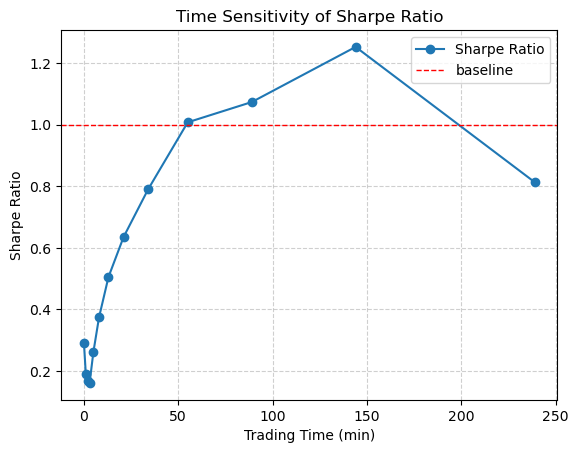

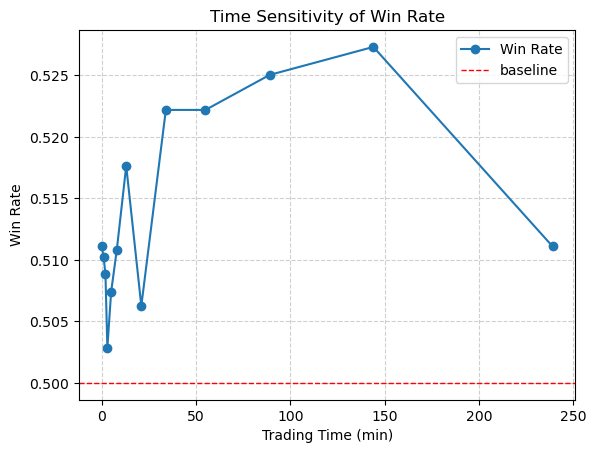

In [204]:
# array of trading time
fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]
sharpe_sensitivity, win_rate_sensitivity = mydata.generate_time_dependency(fibonnacci, "IC_momentum_st2")

# plot sensitivity
plot_metric(fibonnacci, sharpe_sensitivity, "Sharpe Ratio", 1)
plot_metric(fibonnacci, win_rate_sensitivity, "Win Rate", 0.5)